In [2]:
#Import relevant Packages 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from scipy import stats
from statsmodels.compat import lzip
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols

import geopandas as gpd
from shapely.geometry import point, polygon
import descartes
from IPython.core.display import HTML

In [3]:
#loading House_Data

df_base = pd.read_csv('kc_house_data.csv')
df_base.reset_index()

,index,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,21592,263000018,5/21/2014,360000.0,3,2.50,1530,1131,3.0,0.0,...,8,1530,0.0,2009,0.0,98103,47.6993,-122.346,1530,1509
21593,21593,6600060120,2/23/2015,400000.0,4,2.50,2310,5813,2.0,0.0,...,8,2310,0.0,2014,0.0,98146,47.5107,-122.362,1830,7200
21594,21594,1523300141,6/23/2014,402101.0,2,0.75,1020,1350,2.0,0.0,...,7,1020,0.0,2009,0.0,98144,47.5944,-122.299,1020,2007
21595,21595,291310100,1/16/2015,400000.0,3,2.50,1600,2388,2.0,NaN,...,8,1600,0.0,2004,0.0,98027,47.5345,-122.069,1410,1287


In [4]:
#Data Cleaning - Removing 'id' duplicates keeping the most recent selling date
 
df_base = df_base.sort_values('date').drop_duplicates('id', keep='first')
df_base.sort_values('id', ascending = True, inplace = True)

In [5]:
#Checking for Nulls in the DataSet

df_base.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2355
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3812
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

In [6]:
#Null approach:

#Waterfront - removing waterfront column as it is uncorrelated to the price variable. 
#Additionally, Seattle is surounded by bodies of water where water views are not a differentiator. 

df_base = df_base.drop(['waterfront'], axis =1)

In [19]:
#Replace zero values with nan, then nan with yr_built

df_base['yr_renovated']=df_base['yr_renovated'].replace(0,np.nan)
df_base['yr_renovated'].fillna(df_base['yr_built'], inplace = True)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
11587,7284900030,5/22/2014,850000.0,4,3.25,3090,6744,2.0,4.0,3,9,3090,0.0,1923,2015.0,98177,47.7680,-122.388,2020,6656
21356,6169901185,5/20/2014,490000.0,5,3.50,4460,2975,3.0,2.0,3,10,3280,?,2015,2015.0,98119,47.6313,-122.370,2490,4231
17084,9126100346,6/17/2014,350000.0,3,2.00,1380,3600,3.0,0.0,3,8,1380,0.0,2015,2015.0,98122,47.6074,-122.305,1480,3600
21317,2424059174,5/8/2015,2000000.0,4,3.25,5640,35006,2.0,2.0,3,11,4900,740.0,2015,2015.0,98006,47.5491,-122.104,4920,35033
21485,4233600150,2/3/2015,1150000.0,5,4.25,4010,8252,2.0,0.0,3,10,4010,0.0,2015,2015.0,98075,47.5974,-122.013,3370,8252


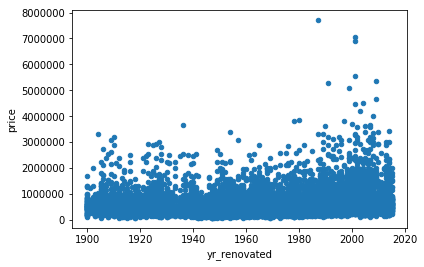

In [20]:
#Plotting the year renovated with price
df_base = df_base.sort_values('yr_renovated', ascending = False)
display(df_base.head())
df_base.plot(kind = 'scatter', x = 'yr_renovated', y = 'price')

In [21]:
#View - for the number of viewings we make an assumption that no viewings (0 value) have been made where the value is null.
#The number of nulls in view is unsignificant in the dataset (<1%)

#yr_renovated - we make the assumption here that no renovation has occured for null values in yr_renovated. 

df_base.fillna(0, inplace = True)

df_base.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
11587,7284900030,5/22/2014,850000.0,4,3.25,3090,6744,2.0,4.0,3,9,3090,0.0,1923,2015.0,98177,47.7680,-122.388,2020,6656
21356,6169901185,5/20/2014,490000.0,5,3.50,4460,2975,3.0,2.0,3,10,3280,?,2015,2015.0,98119,47.6313,-122.370,2490,4231
17084,9126100346,6/17/2014,350000.0,3,2.00,1380,3600,3.0,0.0,3,8,1380,0.0,2015,2015.0,98122,47.6074,-122.305,1480,3600
21317,2424059174,5/8/2015,2000000.0,4,3.25,5640,35006,2.0,2.0,3,11,4900,740.0,2015,2015.0,98006,47.5491,-122.104,4920,35033
21485,4233600150,2/3/2015,1150000.0,5,4.25,4010,8252,2.0,0.0,3,10,4010,0.0,2015,2015.0,98075,47.5974,-122.013,3370,8252


In [22]:
#Removing 'question marks' characters from dataframe 

df_base.replace({'?':np.nan}).dropna()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
11587,7284900030,5/22/2014,850000.0,4,3.25,3090,6744,2.0,4.0,3,9,3090,0.0,1923,2015.0,98177,47.7680,-122.388,2020,6656
17084,9126100346,6/17/2014,350000.0,3,2.00,1380,3600,3.0,0.0,3,8,1380,0.0,2015,2015.0,98122,47.6074,-122.305,1480,3600
21317,2424059174,5/8/2015,2000000.0,4,3.25,5640,35006,2.0,2.0,3,11,4900,740.0,2015,2015.0,98006,47.5491,-122.104,4920,35033
21485,4233600150,2/3/2015,1150000.0,5,4.25,4010,8252,2.0,0.0,3,10,4010,0.0,2015,2015.0,98075,47.5974,-122.013,3370,8252
19706,9161100075,3/18/2015,673000.0,4,2.25,2580,2875,2.0,0.0,3,9,2580,0.0,2015,2015.0,98116,47.5674,-122.392,1290,5750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5367,3058600050,9/19/2014,285000.0,2,1.00,920,5850,1.0,0.0,4,6,920,0.0,1900,1900.0,98108,47.5441,-122.304,1640,5476
12763,7228500610,3/30/2015,510000.0,2,1.00,1070,5280,1.0,0.0,3,6,1070,0.0,1900,1900.0,98122,47.6168,-122.303,1380,2370
15729,9828702895,10/22/2014,700000.0,4,1.75,2420,520,1.5,0.0,3,7,2420,0.0,1900,1900.0,98112,47.6209,-122.302,1200,1170
3128,9829200590,10/28/2014,759000.0,3,2.75,1960,6390,1.5,2.0,5,8,1960,0.0,1900,1900.0,98122,47.6032,-122.285,2440,5870


In [23]:
#Re-checking for nulls

df_base.isna().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64